In [138]:
using Plots, JLD, OffsetArrays, LinearAlgebra, ConfParser, ProgressMeter, Colors, Statistics,
    EllipsisNotation, Images
import OffsetArrays: no_offset_view

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1278


In [5]:
function generateConfig(params)
    k, uf, fs_radius, λ₁, λ₂, λ₃ = params
    open("measurements/trial_2/$k.conf", "w") do f
        write(f, """
N                     1500
undersampling_rate    $uf
fully_sampled_radius  $fs_radius
lambda_1              $λ₁
lambda_2              $λ₂
lambda_3              $λ₃
verbose               true
        """)
    end
end

generateConfig (generic function with 1 method)

In [7]:
log_range = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4]
grid = [(uf, 0.1, λ₁, λ₂, λ₃) for uf in 0.2:0.2:0.9, λ₁ in log_range, λ₂ in log_range,
        λ₃ in 0.01:0.025:0.1]
grid = enumerate(vec(grid))
grid = [(i, p...) for (i,p) in grid]
@show length(grid)

length(grid) = 400


400

In [345]:
generateConfig.(grid);

In [9]:
@load "data.jld"

2-element Array{Symbol,1}:
 :image4D
 :kSpace

In [10]:
image3D = sum(image4D, dims = 4)
image3D_norm = norm(image3D)
mse_temp = similar(image3D)
mse(img) = norm(sum!(mse_temp, img) .-= image3D) / image3D_norm

mse (generic function with 1 method)

In [51]:
function imshow(img::Array{T, 2}; shift = false) where T<:Number
    plot(Gray.(abs.(img)'), seriestype=:image)
end

imshow (generic function with 1 method)

In [325]:
p = Progress(length(grid), 1)
NMSE_vec, f_vec = [[Dict() for _ in 1:4] for _ in 1:2]
foreach(readdir("measurements/trial_2/")) do f
    if endswith(f, ".jld")
        conf_filename = "measurements/trial_2/" * split(f, ".")[1] * ".conf"
        conf = ConfParse(conf_filename)
        parse_conf!(conf)
        undersampling_rate = parse(Float64, retrieve(conf, "undersampling_rate"))
        uf = round(Int, undersampling_rate * 5)
        λ₁ = parse(Float64, retrieve(conf, "lambda_1"))
        λ₂ = parse(Float64, retrieve(conf, "lambda_2"))
        λ₃ = parse(Float64, retrieve(conf, "lambda_3"))
        d = load("measurements/trial_2/"*f)
        NMSE_vec[uf]["$(split(f, ".")[1]) | λ₁: $λ₁, λ₂: $λ₂, λ₃: $λ₃"] = d["NMSE_vec_pogm"]
        f_vec[uf]["$(split(f, ".")[1]) | λ₁: $λ₁, λ₂: $λ₂, λ₃: $λ₃"] = d["f_vec_pogm"]
        next!(p)
    end
end
finish!(p)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


In [326]:
NMSE_vec[1]["385 | λ₁: 5.0e-6, λ₂: 0.0001, λ₃: 0.085"][142:end] .= NaN;

best_label_2 = "249 | λ₁: 1.0e-5, λ₂: 1.0e-5, λ₃: 0.06"


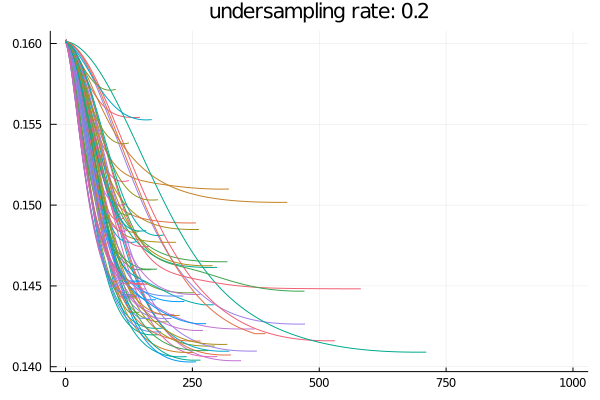

In [327]:
plt = plot(title = "undersampling rate: 0.2", legend = false)
best_label_2, best_value = "", Inf
for (label, series) in NMSE_vec[1]
    series[series .< eps(Float64)] .= NaN
    if minimum(filter(!isnan, series)) < best_value
        best_label_2 = label
        best_value = minimum(filter(!isnan, series))
    end
    any(x -> x > 0.17, series) || plot!(series, label=label)
end
@show best_label_2
plt

best_label_4 = "150 | λ₁: 1.0e-5, λ₂: 1.0e-5, λ₃: 0.035"


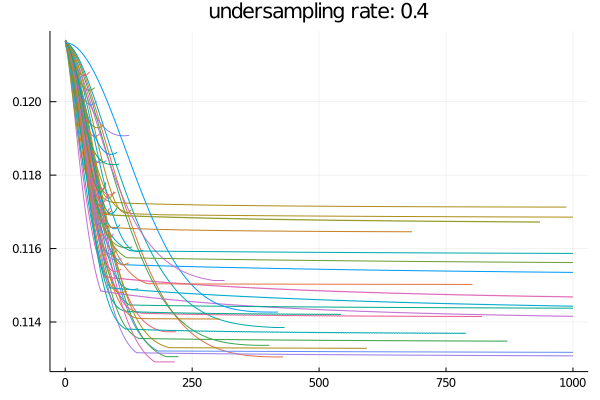

In [328]:
plt = plot(title = "undersampling rate: 0.4", legend = false)
best_label_4, best_value = "", Inf
for (label, series) in NMSE_vec[2]
    series[series .< eps(Float64)] .= NaN
    if minimum(filter(!isnan, series)) < best_value
        best_label_4 = label
        best_value = minimum(filter(!isnan, series))
    end
    any(x -> x > 0.135, series) || plot!(series, label=label)
end
@show best_label_4
plt

best_label_6 = "151 | λ₁: 1.0e-5, λ₂: 1.0e-5, λ₃: 0.035"


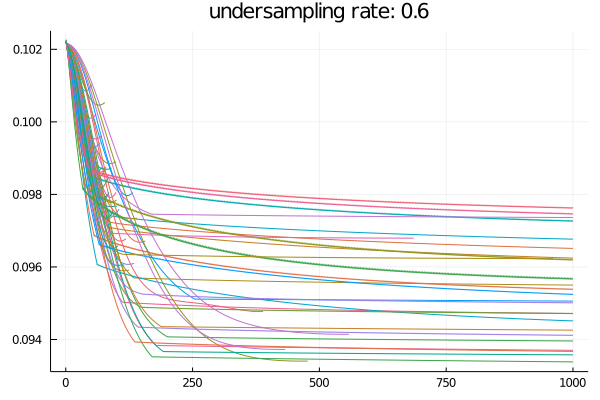

In [329]:
plt = plot(title = "undersampling rate: 0.6", legend = false)
best_label_6, best_value = "", Inf
for (label, series) in NMSE_vec[3]
    series[series .< eps(Float64)] .= NaN
    if minimum(filter(!isnan, series)) < best_value
        best_label_6 = label
        best_value = minimum(filter(!isnan, series))
    end
    any(x -> x > 0.115, series) || plot!(series, label=label)
end
@show best_label_6
plt

best_label_8 = "152 | λ₁: 1.0e-5, λ₂: 1.0e-5, λ₃: 0.035"


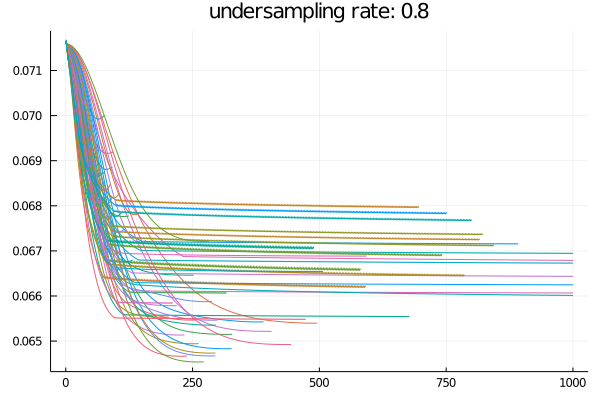

In [330]:
plt = plot(title = "undersampling rate: 0.8", legend = false)
best_label_8, best_value = "", Inf
for (label, series) in NMSE_vec[4]
    series[series .< eps(Float64)] .= NaN
    if minimum(filter(!isnan, series)) < best_value
        best_label_8 = label
        best_value = minimum(filter(!isnan, series))
    end
    any(x -> x > 0.09, series) || plot!(series, label=label)
end
@show best_label_8
plt

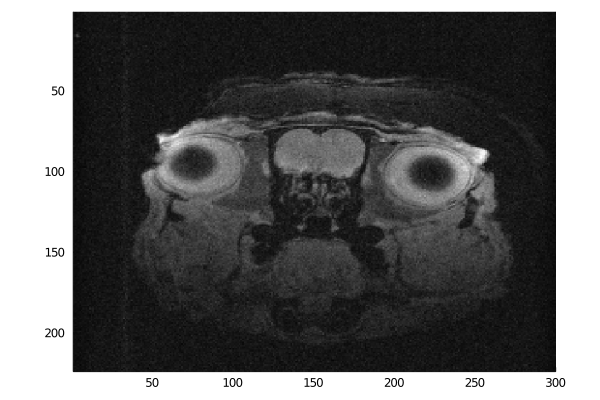

In [331]:
image3D = mean(image4D, dims = 4)[..,48,1]
imshow(image3D ./ maximum(image3D))

assess_ssim(image3D, image3D_2) = 0.8507328549285891
mse(d["image4D_pogm"]) = 0.7860574984472026


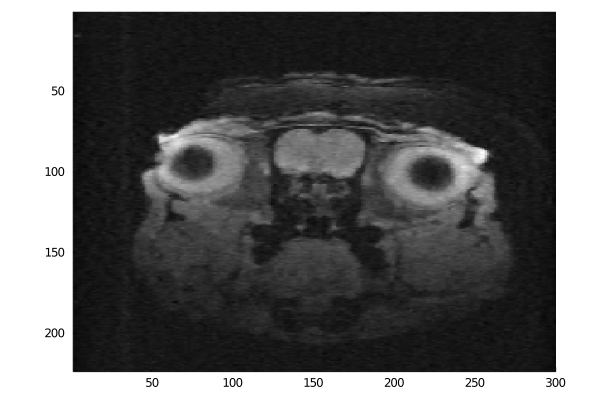

In [332]:
d = load("measurements/trial_2/" * split(best_label_2, " ")[1] * ".jld")
image3D_2 = mean(d["image4D_pogm"], dims = 4)[..,48,1]
@show assess_ssim(image3D, image3D_2)
@show mse(d["image4D_pogm"])
imshow(image3D_2 ./ maximum(image3D_2))

assess_ssim(image3D, image3D_4) = 0.8965405599392023
mse(d["image4D_pogm"]) = 0.7916202075480254


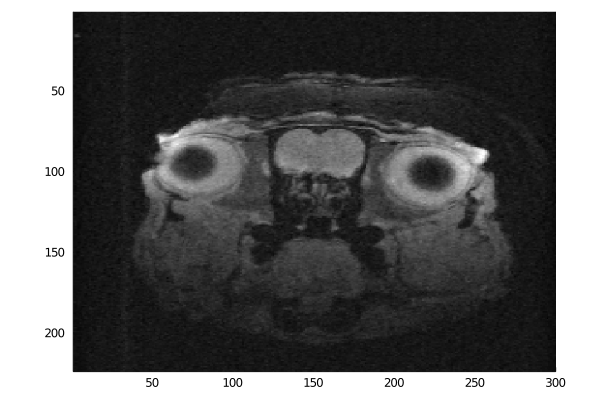

In [333]:
d = load("measurements/trial_2/" * split(best_label_4, " ")[1] * ".jld")
image3D_4 = mean(d["image4D_pogm"], dims = 4)[..,48,1]
@show assess_ssim(image3D, image3D_4)
@show mse(d["image4D_pogm"])
imshow(image3D_4 ./ maximum(image3D_4))

assess_ssim(image3D, image3D_6) = 0.9296303823383837
mse(d["image4D_pogm"]) = 0.7943890235164112


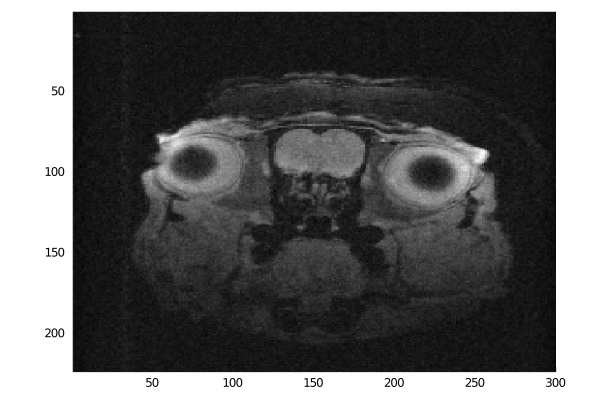

In [334]:
d = load("measurements/trial_2/" * split(best_label_6, " ")[1] * ".jld")
image3D_6 = mean(d["image4D_pogm"], dims = 4)[..,48,1]
@show assess_ssim(image3D, image3D_6)
@show mse(d["image4D_pogm"])
imshow(image3D_6 ./ maximum(image3D_6))

assess_ssim(image3D, image3D_8) = 0.9652583569703831
mse(d["image4D_pogm"]) = 0.7974368331282166


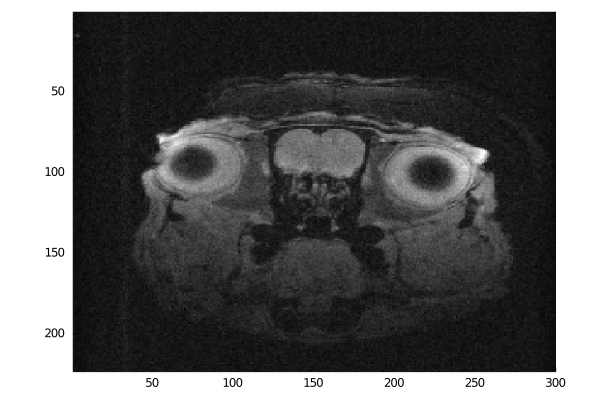

In [335]:
d = load("measurements/trial_2/" * split(best_label_8, " ")[1] * ".jld")
image3D_8 = mean(d["image4D_pogm"], dims = 4)[..,48,1]
@show assess_ssim(image3D, image3D_8)
@show mse(d["image4D_pogm"])
imshow(image3D_8 ./ maximum(image3D_8))

In [336]:
sum(length, NMSE_vec)

274

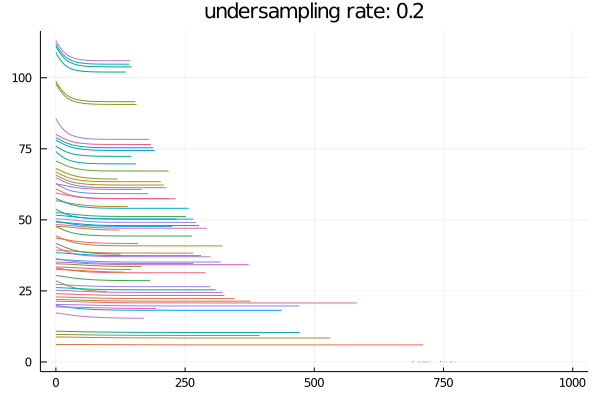

In [337]:
plt = plot(title = "undersampling rate: 0.2", legend = false)
for (label, series) in f_vec[1]
    series[series .< eps(Float64)] .= NaN
    any(x -> x > 1000, series) || plot!(series, label=label)
end
plt

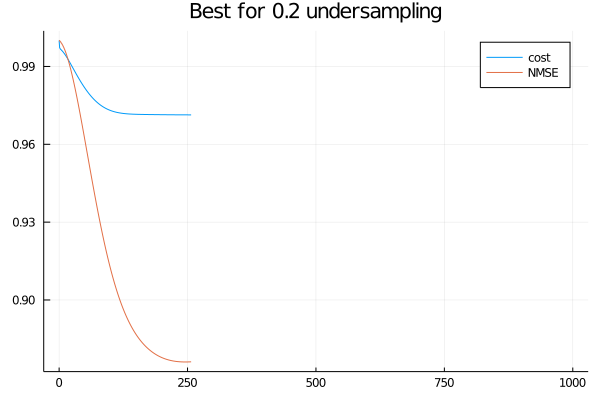

In [338]:
tmp = f_vec[1][best_label_2]
tmp[tmp .> 1000] .= NaN
plot(tmp ./ maximum(filter(!isnan, tmp)),
    title = "Best for 0.2 undersampling", label = "cost")
plot!(NMSE_vec[1][best_label_2] ./ maximum(filter(!isnan, NMSE_vec[1][best_label_2])), label = "NMSE")

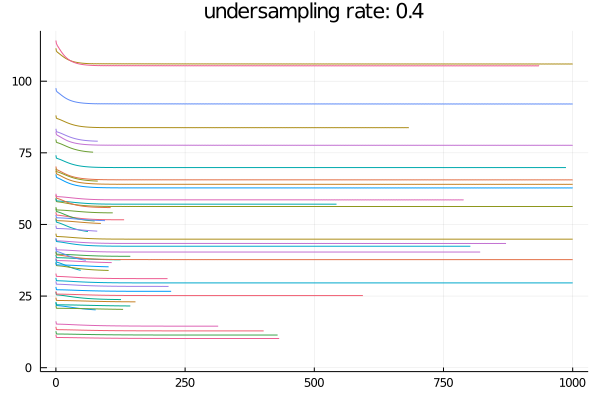

In [339]:
plt = plot(title = "undersampling rate: 0.4", legend = false)
for (label, series) in f_vec[2]
    series[series .< eps(Float64)] .= NaN
    any(x -> x > 1000, series) || plot!(series, label=label)
end
plt

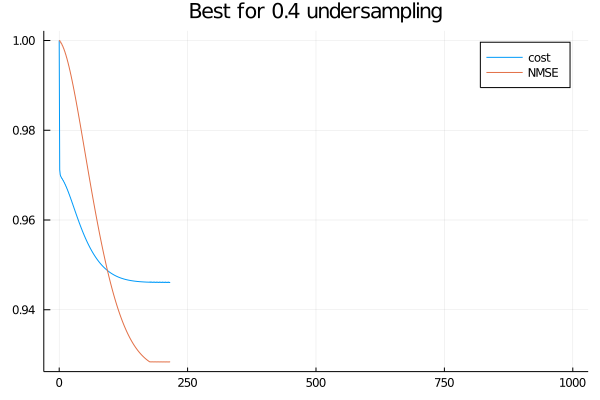

In [340]:
plot(f_vec[2][best_label_4] ./ maximum(filter(!isnan, f_vec[2][best_label_4])),
    title = "Best for 0.4 undersampling", label = "cost")
plot!(NMSE_vec[2][best_label_4] ./ maximum(filter(!isnan, NMSE_vec[2][best_label_4])), label = "NMSE")

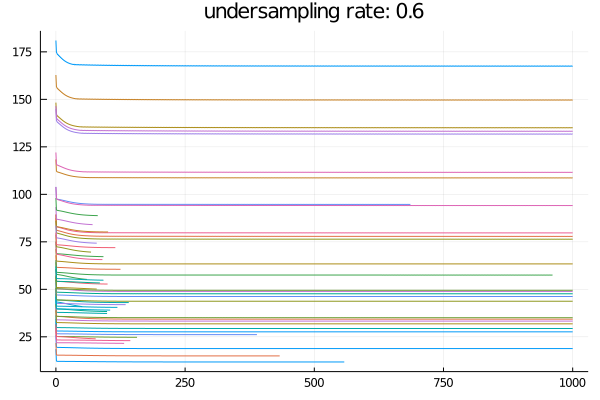

In [341]:
plt = plot(title = "undersampling rate: 0.6", legend = false)
for (label, series) in f_vec[3]
    series[series .< eps(Float64)] .= NaN
    any(x -> x > 1000, series) || plot!(series, label=label)
end
plt

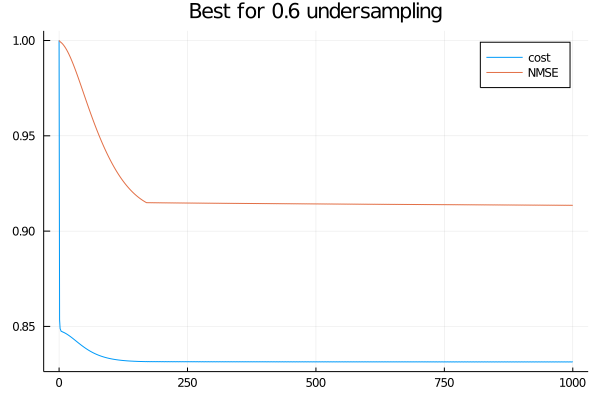

In [342]:
tmp = f_vec[3][best_label_6]
tmp[tmp .> 1000] .= NaN
plot(tmp ./ maximum(filter(!isnan, tmp)),
    title = "Best for 0.6 undersampling", label = "cost")
plot!(NMSE_vec[3][best_label_6] ./ maximum(filter(!isnan, NMSE_vec[3][best_label_6])), label = "NMSE")

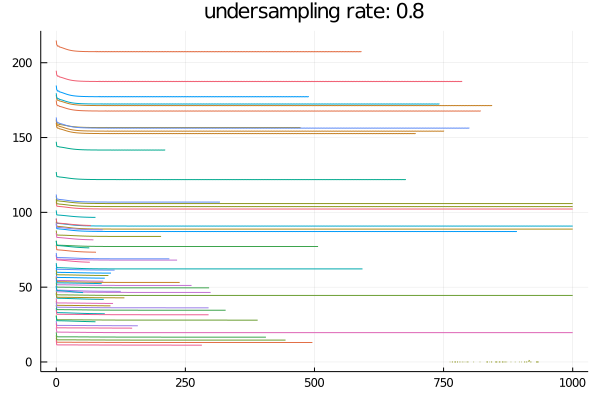

In [343]:
plt = plot(title = "undersampling rate: 0.8", legend = false)
for (label, series) in f_vec[4]
    series[series .< eps(Float64)] .= NaN
    any(x -> x > 1000, series) || plot!(series, label=label)
end
plt

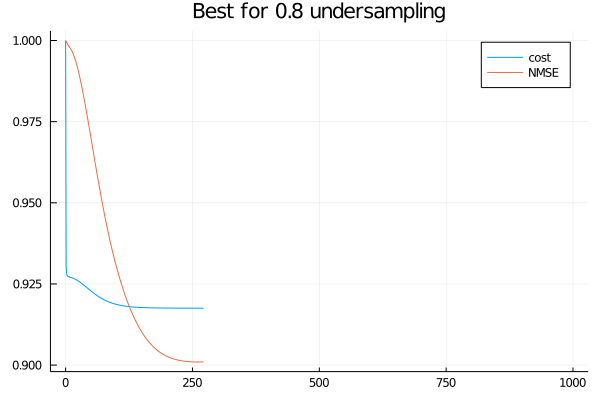

In [344]:
tmp = f_vec[4][best_label_8]
tmp[tmp .> 1000] .= NaN
plot(tmp ./ maximum(filter(!isnan, tmp)),
    title = "Best for 0.8 undersampling", label = "cost")
plot!(NMSE_vec[4][best_label_8] ./ maximum(filter(!isnan, NMSE_vec[4][best_label_8])), label = "NMSE")